<a href="https://colab.research.google.com/github/codejunkes/BBRF103/blob/master/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
#use this if you have a webcam or cammera attached to your computer

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


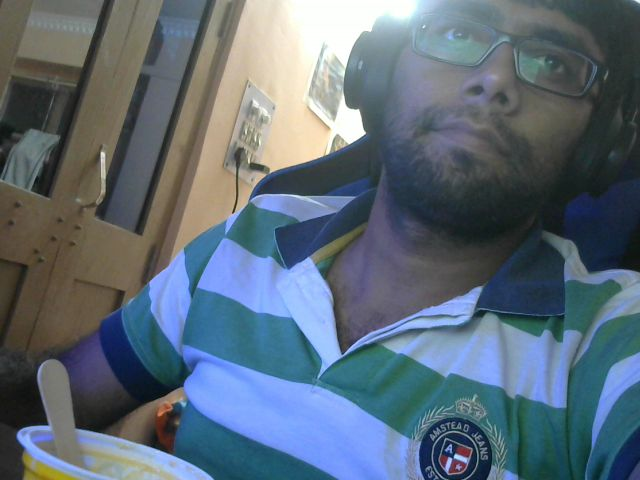

In [0]:
# use this code if you have a webcam or cammera attached to your computer

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving caspian_tir_2017035_lrg.jpg to caspian_tir_2017035_lrg.jpg
User uploaded file "caspian_tir_2017035_lrg.jpg" with length 5436560 bytes


# Spacial Fourier Transform (fft2)

Special fourier transform does fourier transform in x, y direction of a image matrix, typicaly for people from electronics baground we do fourier transform with resxpect to time so it gives us information in frequency domain. Where as if case of special fourier transform we find special frequency.

Fourier transform of function $f(x,y)$:
>$g(u,v)=\int_{-\infty}^\infty \int_{-\infty}^\infty f(x,y) {e^{-2\mathbf{i} \pi k(ux+ vy)}dxdy}$

Inverse Fourier transform of function $F(u,v)$:
>$f(x,y)=\int_{-\infty}^\infty \int_{-\infty}^\infty g(u,v) {e^{2\mathbf{i} \pi k(ux+ vy)}dxdy}$


In [4]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = [int(w / 2), int(h / 2)]
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center >= radius
    return mask


img_RGB = cv2.imread('caspian_tir_2017035_lrg.jpg')
img_B, img_G, img_R = cv2.split(img_RGB)

f = np.fft.fft2(img_B)
fshift_img_B = np.fft.fftshift(f)
magnitude_spectrum_img_B = 20 * np.log(np.abs(fshift_img_B))

f = np.fft.fft2(img_G)
fshift_img_G = np.fft.fftshift(f)
magnitude_spectrum_img_G = 20 * np.log(np.abs(fshift_img_G))

f = np.fft.fft2(img_R)
fshift_img_R = np.fft.fftshift(f)
magnitude_spectrum_img_R = 20 * np.log(np.abs(fshift_img_R))

Radius = 10
rows, cols = img_B.shape
crow, ccol = rows / 2, cols / 2
crow = int(crow)
ccol = int(ccol)
print(crow, ccol)
# fshift_img_B[crow - 100:crow + 100, ccol - 100:ccol + 100] = 0
mask = create_circular_mask(rows, cols, None, Radius)
fshift_img_B = fshift_img_B * mask
fshift_img_B = np.fft.ifftshift(fshift_img_B)
img_back_B = np.fft.ifft2(fshift_img_B)
abs_img_back_B = np.abs(img_back_B)

mask = create_circular_mask(rows, cols, None, Radius)
fshift_img_R = fshift_img_R * mask
fshift_img_R = np.fft.ifftshift(fshift_img_R)
img_back_R = np.fft.ifft2(fshift_img_R)
abs_img_back_R = np.abs(img_back_R)

mask = create_circular_mask(rows, cols, None, Radius)
fshift_img_G = fshift_img_G * mask
fshift_img_G = np.fft.ifftshift(fshift_img_G)
img_back_G = np.fft.ifft2(fshift_img_B)
abs_img_back_G = np.abs(img_back_G)

abs_image_back = cv2.merge((abs_img_back_B, abs_img_back_G, abs_img_back_R))


1085 1627


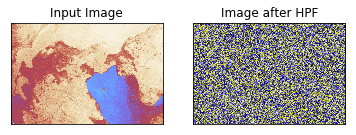

In [5]:
plt.subplot(121), plt.imshow(img_RGB)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow((abs_image_back * 255).astype(np.uint8))
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

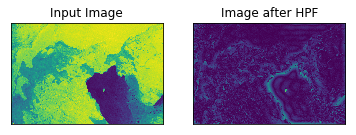

In [6]:
plt.subplot(121), plt.imshow(img_B)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(abs_img_back_B)
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()


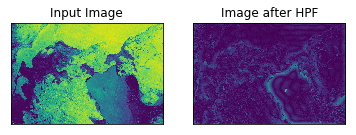

In [7]:
plt.subplot(121), plt.imshow(img_G)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(abs_img_back_G)
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()


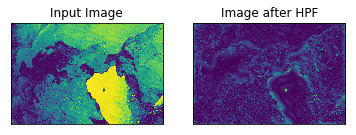

In [8]:
plt.subplot(121), plt.imshow(img_R)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(abs_img_back_R)
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
cv2.imwrite('abs_img_back_B.jpg',abs_img_back_G)
files.download('abs_img_back_B.jpg')